## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import SRMSE
import VAE

## Choose Variables and Preprocess

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','AGEP','JWMNP','SEX','SCHL','COW','DPHY','DEYE','DREM','DOUT','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
pums_data['AGEP'], agep_bins = pd.qcut(pums_data['AGEP'], q=10, labels=False, retbins=True)
pums_data['JWMNP'], jwmnp_bins = pd.qcut(pums_data['JWMNP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,AGEP,JWMNP,SEX,SCHL,COW,DPHY,DEYE,DREM,DOUT,RAC1P,HINCP,NP,VEH,BLD,ACCESS
4,6,9.0,1,21.0,1.0,2.0,2,2.0,2.0,1,9.0,3,3.0,2.0,1.0
5,6,4.0,2,21.0,3.0,2.0,2,2.0,2.0,1,9.0,3,3.0,2.0,1.0
7,7,6.0,1,19.0,3.0,2.0,2,2.0,2.0,1,3.0,2,3.0,1.0,3.0
8,6,2.0,2,16.0,1.0,2.0,2,2.0,2.0,1,3.0,2,3.0,1.0,3.0
9,4,0.0,1,5.0,1.0,2.0,2,2.0,2.0,9,1.0,5,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,4,8.0,1,21.0,1.0,2.0,2,2.0,2.0,6,3.0,3,2.0,2.0,1.0
356010,3,9.0,1,18.0,1.0,2.0,2,2.0,2.0,1,6.0,4,2.0,3.0,1.0
356013,5,9.0,1,18.0,1.0,2.0,2,2.0,2.0,1,6.0,3,4.0,2.0,1.0
356014,5,6.0,2,19.0,1.0,2.0,2,2.0,2.0,1,6.0,3,4.0,2.0,1.0


In [3]:
HH_IDX = pums_data_p.shape[1] - 1  # Index of household variables start
VAR_DIM = pums_data.shape[1]  # Length of all variables before OHE
VAR_NAMES = pums_data.columns  # Names of all variables before OHE
HH_VAR_NAMES = pums_data_h.columns  # Names of the hh variables

del pums_data_p
del pums_data_h

# Split categorical data into OHE vars, save num classes per variable, as well as numeric encodings per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
    del dummies
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [9, 10, 2, 24, 8, 2, 2, 2, 2, 9, 10, 18, 7, 10, 3]


In [4]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
del ohe_var
MANIFEST_DIM = model_data_df.shape[1]
HH_IDX_MANIFEST = sum(CAT_LENGTHS[:HH_IDX])

# Add columns for original household variables; these will be used as conditionals
model_data_df = pd.concat([model_data_df, model_data_df.iloc[:,HH_IDX_MANIFEST:]], axis=1)

# Preview data that will be fed into model
model_data_df

,AGEP__1,AGEP__2,AGEP__3,AGEP__4,AGEP__5,AGEP__6,AGEP__7,AGEP__8,AGEP__9,JWMNP__0.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
356010,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
356013,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
356014,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.0007)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 105 samples


## Set Parameters and Define Model

In [6]:
# Grid Search SRMSE 1
# BATCH_SIZES = [64, 128, 256, 512, 1024]
# EPOCHS = [1000]
# LATENT_DIMS = [4, 6, 8]
# HIDDEN_DIMS = [8, 16, 32, 64]
# KL_WEIGHTS = [.01, .05, .1, 1.0]
# [313.08608531951904, 11.0505690574646, 0.02598349649036663, 0.006970305382407434, [512, 1000, 6, 64, 0.1]]
# [290.68157863616943, 6.595394611358643, 0.026173123522601732, 0.00692727365319053, [256, 1000, 6, 64, 0.1]]
# [99.60163021087646, 6.652237892150879, 0.028944710845045213, 0.0071278053533916155, [1024, 1000, 8, 16, 0.05]]

# Hyperparameters
BATCH_SIZE = 512
EPOCHS = 1000
LATENT_DIM = 6
HIDDEN_DIM = 64
KL_WEIGHT = .1

## Training

In [7]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(loss_cat)

In [8]:
# # Load in the synthetic households
# synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
# synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# # Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
# synth_hh_df['HH_ID'] = synth_hh_df.index
# synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
# synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

def testModel(test_vae, latent_dim):
    # How many synthetic households to fill
    POP_SIZE = len(synth_hh_ohe_df)

    # Generate random normal sample to represent each latent variable, for each row (different person per row)
    np.random.seed(42)
    epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, latent_dim))

    start_time = time.time()
    # Generate persons; each person has unique latent input, plus shared hh inputs with their household
    results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])
    gen_time = time.time() - start_time

    # Convert the test results from logits to values
    synth_p_df = pd.DataFrame()
    for i, x in enumerate(results[0]):
        result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
        result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
        synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
    synth_p_df.columns = VAR_NAMES

    # Assign the control variables from the synthetic households to individuals (replace what came from the model)
    for var in HH_VAR_NAMES[1:]:
        synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

    srmse_uni = SRMSE.calculateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))
    srmse_bi = SRMSE.calculateBivariateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))

    return gen_time, srmse_uni, srmse_bi

In [9]:
# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     print(f"[{bs}, {e}, {ld}, {hd}, {klw}]")
#                     start_time = time.time()
#                     vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, HH_IDX, klw)
#                     vae.compile(optimizer=keras.optimizers.Adam())
#                     history = vae.fit(train_data, epochs=e, batch_size=bs, callbacks=[validationCallback()], verbose=0)
#                     train_time = (time.time()-start_time)
#                     gen_time, srmse_uni, srmse_bi = testModel(test_vae=vae, latent_dim=ld)
#                     results = [train_time, gen_time, srmse_uni, srmse_bi, [bs,e,ld,hd,klw]]
#                     grid_search_results.append(results)

# # Find the best results for each metric in the grid search
# min_srmse_uni_idx = 0
# min_srmse_uni_value = 999999999
# min_srmse_bi_idx = 0
# min_srmse_bi_value = 999999999
# min_eff_idx = 0
# min_eff_value = 999999999
# for i, result in enumerate(grid_search_results):
#     tot_time = result[0]+result[1]
#     time_eff = (result[2]+result[3] / 2) * tot_time
#     if result[2] < min_srmse_uni_value:
#         min_srmse_uni_idx = i
#         min_srmse_uni_value = result[2]
#     if result[3] < min_srmse_bi_value:
#         min_srmse_bi_idx = i
#         min_srmse_bi_value = result[3]
#     if time_eff < min_eff_value:
#         min_eff_idx = i
#         min_eff_value = time_eff

# # Display the results
# print(grid_search_results[min_srmse_uni_idx])
# print(grid_search_results[min_srmse_bi_idx])
# print(grid_search_results[min_eff_idx])

In [10]:
# Train the model using single set of hyperparameters
start_time = time.time()
vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])
print(f"--- {time.time() - start_time} seconds ---")

Epoch 1/1000
1/1 [==============================] - 0s 453ms/step - tot_loss: 26.7410 - rec_loss: 26.6625 - kl_loss: 0.0785
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 26.0702 - rec_loss: 25.9852 - kl_loss: 0.0849
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 25.5254 - rec_loss: 25.4256 - kl_loss: 0.0997
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 25.1597 - rec_loss: 25.0377 - kl_loss: 0.1220
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 24.5019 - rec_loss: 24.3509 - kl_loss: 0.1511
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 24.0859 - rec_loss: 23.8998 - kl_loss: 0.1861
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 23.5031 - rec_loss: 23.2770 - kl_loss: 0.2261
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 23.1314 - rec_loss: 22.8607 - kl_loss: 0.2707
Epoch 9/1000
1/1 [====

1/1 [==============================] - 0s 2ms/step - tot_loss: 12.3127 - rec_loss: 11.8460 - kl_loss: 0.4667
Epoch 68/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 12.1823 - rec_loss: 11.7122 - kl_loss: 0.4702
Epoch 69/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 12.1440 - rec_loss: 11.6709 - kl_loss: 0.4731
Epoch 70/1000
1/1 [==============================] - 0s 5ms/step - tot_loss: 12.0368 - rec_loss: 11.5614 - kl_loss: 0.4754
Epoch 71/1000
1/1 [==============================] - 0s 140ms/step - tot_loss: 11.8832 - rec_loss: 11.4044 - kl_loss: 0.4788
Epoch 72/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 11.8822 - rec_loss: 11.3993 - kl_loss: 0.4829
Epoch 73/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 11.7277 - rec_loss: 11.2389 - kl_loss: 0.4888
Epoch 74/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 11.6804 - rec_loss: 11.1864 - kl_loss: 0.4940
Epoch 75/1000
1/1 [=========

1/1 [==============================] - 0s 3ms/step - tot_loss: 7.5922 - rec_loss: 6.9345 - kl_loss: 0.6578
Epoch 135/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 7.5738 - rec_loss: 6.9153 - kl_loss: 0.6585
Epoch 136/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 7.5073 - rec_loss: 6.8473 - kl_loss: 0.6599
Epoch 137/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 7.4667 - rec_loss: 6.8051 - kl_loss: 0.6616
Epoch 138/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 7.4098 - rec_loss: 6.7466 - kl_loss: 0.6632
Epoch 139/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 7.3374 - rec_loss: 6.6727 - kl_loss: 0.6647
Epoch 140/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 7.3330 - rec_loss: 6.6673 - kl_loss: 0.6657
Epoch 141/1000
1/1 [==============================] - 0s 84ms/step - tot_loss: 7.2683 - rec_loss: 6.6016 - kl_loss: 0.6668
Epoch 142/1000
1/1 [==================

1/1 [==============================] - 0s 114ms/step - tot_loss: 5.0283 - rec_loss: 4.3116 - kl_loss: 0.7166
Epoch 202/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 4.9789 - rec_loss: 4.2606 - kl_loss: 0.7183
Epoch 203/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 4.9561 - rec_loss: 4.2363 - kl_loss: 0.7198
Epoch 204/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 4.9427 - rec_loss: 4.2220 - kl_loss: 0.7208
Epoch 205/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 4.9136 - rec_loss: 4.1920 - kl_loss: 0.7216
Epoch 206/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 4.8441 - rec_loss: 4.1216 - kl_loss: 0.7225
Epoch 207/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 4.8404 - rec_loss: 4.1171 - kl_loss: 0.7233
Epoch 208/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 4.8646 - rec_loss: 4.1408 - kl_loss: 0.7238
Epoch 209/1000
1/1 [=================

1/1 [==============================] - 0s 2ms/step - tot_loss: 3.5137 - rec_loss: 2.7642 - kl_loss: 0.7496
Epoch 269/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 3.4939 - rec_loss: 2.7435 - kl_loss: 0.7503
Epoch 270/1000
1/1 [==============================] - 0s 6ms/step - tot_loss: 3.4850 - rec_loss: 2.7343 - kl_loss: 0.7507
Epoch 271/1000
1/1 [==============================] - 0s 142ms/step - tot_loss: 3.5184 - rec_loss: 2.7674 - kl_loss: 0.7510
Epoch 272/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 3.4698 - rec_loss: 2.7184 - kl_loss: 0.7514
Epoch 273/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 3.4524 - rec_loss: 2.7008 - kl_loss: 0.7515
Epoch 274/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 3.4254 - rec_loss: 2.6739 - kl_loss: 0.7515
Epoch 275/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 3.4052 - rec_loss: 2.6545 - kl_loss: 0.7507
Epoch 276/1000
1/1 [=================

1/1 [==============================] - 0s 8ms/step - tot_loss: 2.6137 - rec_loss: 1.8692 - kl_loss: 0.7445
Epoch 336/1000
1/1 [==============================] - 0s 7ms/step - tot_loss: 2.6216 - rec_loss: 1.8770 - kl_loss: 0.7446
Epoch 337/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 2.5824 - rec_loss: 1.8386 - kl_loss: 0.7438
Epoch 338/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 2.6276 - rec_loss: 1.8854 - kl_loss: 0.7423
Epoch 339/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 2.5705 - rec_loss: 1.8290 - kl_loss: 0.7414
Epoch 340/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 2.5705 - rec_loss: 1.8297 - kl_loss: 0.7407
Epoch 341/1000
1/1 [==============================] - 0s 126ms/step - tot_loss: 2.5567 - rec_loss: 1.8167 - kl_loss: 0.7400
Epoch 342/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 2.5446 - rec_loss: 1.8049 - kl_loss: 0.7396
Epoch 343/1000
1/1 [=================

1/1 [==============================] - 0s 3ms/step - tot_loss: 2.0260 - rec_loss: 1.3130 - kl_loss: 0.7130
Epoch 403/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 2.0387 - rec_loss: 1.3269 - kl_loss: 0.7118
Epoch 404/1000
1/1 [==============================] - 0s 6ms/step - tot_loss: 2.0564 - rec_loss: 1.3460 - kl_loss: 0.7104
Epoch 405/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 2.0102 - rec_loss: 1.3005 - kl_loss: 0.7096
Epoch 406/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 2.0436 - rec_loss: 1.3351 - kl_loss: 0.7085
Epoch 407/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 2.0121 - rec_loss: 1.3044 - kl_loss: 0.7076
Epoch 408/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 2.0552 - rec_loss: 1.3487 - kl_loss: 0.7065
Epoch 409/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.9946 - rec_loss: 1.2886 - kl_loss: 0.7060
Epoch 410/1000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - tot_loss: 1.6899 - rec_loss: 1.0121 - kl_loss: 0.6778
Epoch 470/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.7123 - rec_loss: 1.0346 - kl_loss: 0.6777
Epoch 471/1000
1/1 [==============================] - 0s 76ms/step - tot_loss: 1.6553 - rec_loss: 0.9768 - kl_loss: 0.6785
Epoch 472/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.6502 - rec_loss: 0.9714 - kl_loss: 0.6788
Epoch 473/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.6497 - rec_loss: 0.9712 - kl_loss: 0.6784
Epoch 474/1000
1/1 [==============================] - 0s 5ms/step - tot_loss: 1.6239 - rec_loss: 0.9466 - kl_loss: 0.6773
Epoch 475/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.6788 - rec_loss: 1.0036 - kl_loss: 0.6751
Epoch 476/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.6739 - rec_loss: 1.0008 - kl_loss: 0.6731
Epoch 477/1000
1/1 [==================

1/1 [==============================] - 0s 2ms/step - tot_loss: 1.4637 - rec_loss: 0.8227 - kl_loss: 0.6410
Epoch 537/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.4214 - rec_loss: 0.7786 - kl_loss: 0.6428
Epoch 538/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.4059 - rec_loss: 0.7614 - kl_loss: 0.6445
Epoch 539/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.4522 - rec_loss: 0.8067 - kl_loss: 0.6454
Epoch 540/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.4263 - rec_loss: 0.7799 - kl_loss: 0.6465
Epoch 541/1000
1/1 [==============================] - 0s 74ms/step - tot_loss: 1.4279 - rec_loss: 0.7806 - kl_loss: 0.6473
Epoch 542/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.4518 - rec_loss: 0.8035 - kl_loss: 0.6482
Epoch 543/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.3996 - rec_loss: 0.7497 - kl_loss: 0.6499
Epoch 544/1000
1/1 [==================

1/1 [==============================] - 0s 1ms/step - tot_loss: 1.2634 - rec_loss: 0.6529 - kl_loss: 0.6106
Epoch 604/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 1.2477 - rec_loss: 0.6370 - kl_loss: 0.6107
Epoch 605/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.2446 - rec_loss: 0.6338 - kl_loss: 0.6108
Epoch 606/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 1.2456 - rec_loss: 0.6349 - kl_loss: 0.6107
Epoch 607/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 1.2619 - rec_loss: 0.6512 - kl_loss: 0.6107
Epoch 608/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.2065 - rec_loss: 0.5953 - kl_loss: 0.6112
Epoch 609/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 1.2539 - rec_loss: 0.6429 - kl_loss: 0.6110
Epoch 610/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.2751 - rec_loss: 0.6636 - kl_loss: 0.6115
Epoch 611/1000
1/1 [===================

1/1 [==============================] - 0s 1ms/step - tot_loss: 1.1262 - rec_loss: 0.5282 - kl_loss: 0.5980
Epoch 671/1000
1/1 [==============================] - 0s 77ms/step - tot_loss: 1.1347 - rec_loss: 0.5379 - kl_loss: 0.5968
Epoch 672/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.1243 - rec_loss: 0.5288 - kl_loss: 0.5955
Epoch 673/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.1041 - rec_loss: 0.5099 - kl_loss: 0.5942
Epoch 674/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.1215 - rec_loss: 0.5292 - kl_loss: 0.5924
Epoch 675/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.1019 - rec_loss: 0.5113 - kl_loss: 0.5906
Epoch 676/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.1088 - rec_loss: 0.5200 - kl_loss: 0.5888
Epoch 677/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.1010 - rec_loss: 0.5140 - kl_loss: 0.5870
Epoch 678/1000
1/1 [==================

1/1 [==============================] - 0s 3ms/step - tot_loss: 1.0203 - rec_loss: 0.4415 - kl_loss: 0.5788
Epoch 738/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.0435 - rec_loss: 0.4649 - kl_loss: 0.5786
Epoch 739/1000
1/1 [==============================] - 0s 5ms/step - tot_loss: 1.0199 - rec_loss: 0.4417 - kl_loss: 0.5783
Epoch 740/1000
1/1 [==============================] - 0s 4ms/step - tot_loss: 1.0324 - rec_loss: 0.4550 - kl_loss: 0.5774
Epoch 741/1000
1/1 [==============================] - 0s 73ms/step - tot_loss: 1.0249 - rec_loss: 0.4486 - kl_loss: 0.5764
Epoch 742/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.0658 - rec_loss: 0.4909 - kl_loss: 0.5749
Epoch 743/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 1.0276 - rec_loss: 0.4530 - kl_loss: 0.5746
Epoch 744/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 1.0313 - rec_loss: 0.4567 - kl_loss: 0.5746
Epoch 745/1000
1/1 [==================

1/1 [==============================] - 0s 1ms/step - tot_loss: 0.9409 - rec_loss: 0.3863 - kl_loss: 0.5547
Epoch 805/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 1.0020 - rec_loss: 0.4502 - kl_loss: 0.5518
Epoch 806/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.9480 - rec_loss: 0.3975 - kl_loss: 0.5505
Epoch 807/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.9846 - rec_loss: 0.4356 - kl_loss: 0.5490
Epoch 808/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.9482 - rec_loss: 0.3997 - kl_loss: 0.5485
Epoch 809/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.9310 - rec_loss: 0.3829 - kl_loss: 0.5481
Epoch 810/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.9733 - rec_loss: 0.4255 - kl_loss: 0.5478
Epoch 811/1000
1/1 [==============================] - 0s 72ms/step - tot_loss: 0.9497 - rec_loss: 0.4014 - kl_loss: 0.5483
Epoch 812/1000
1/1 [==================

1/1 [==============================] - 0s 69ms/step - tot_loss: 0.8980 - rec_loss: 0.3714 - kl_loss: 0.5267
Epoch 872/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8830 - rec_loss: 0.3555 - kl_loss: 0.5275
Epoch 873/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8720 - rec_loss: 0.3444 - kl_loss: 0.5276
Epoch 874/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8917 - rec_loss: 0.3645 - kl_loss: 0.5271
Epoch 875/1000
1/1 [==============================] - 0s 3ms/step - tot_loss: 0.8697 - rec_loss: 0.3427 - kl_loss: 0.5271
Epoch 876/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8680 - rec_loss: 0.3411 - kl_loss: 0.5269
Epoch 877/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8685 - rec_loss: 0.3415 - kl_loss: 0.5270
Epoch 878/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.8521 - rec_loss: 0.3253 - kl_loss: 0.5268
Epoch 879/1000
1/1 [==================

1/1 [==============================] - 0s 2ms/step - tot_loss: 0.8335 - rec_loss: 0.3316 - kl_loss: 0.5019
Epoch 939/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8089 - rec_loss: 0.3047 - kl_loss: 0.5042
Epoch 940/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8262 - rec_loss: 0.3205 - kl_loss: 0.5057
Epoch 941/1000
1/1 [==============================] - 0s 71ms/step - tot_loss: 0.8483 - rec_loss: 0.3414 - kl_loss: 0.5069
Epoch 942/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8416 - rec_loss: 0.3328 - kl_loss: 0.5088
Epoch 943/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8010 - rec_loss: 0.2896 - kl_loss: 0.5114
Epoch 944/1000
1/1 [==============================] - 0s 1ms/step - tot_loss: 0.8383 - rec_loss: 0.3250 - kl_loss: 0.5133
Epoch 945/1000
1/1 [==============================] - 0s 2ms/step - tot_loss: 0.8045 - rec_loss: 0.2895 - kl_loss: 0.5150
Epoch 946/1000
1/1 [==================

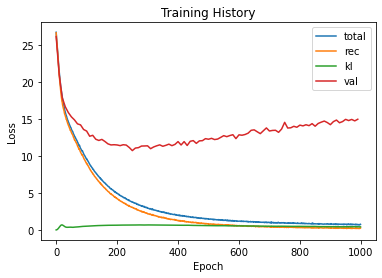

In [11]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl","val"], loc="upper right")
plt.show()

## Testing

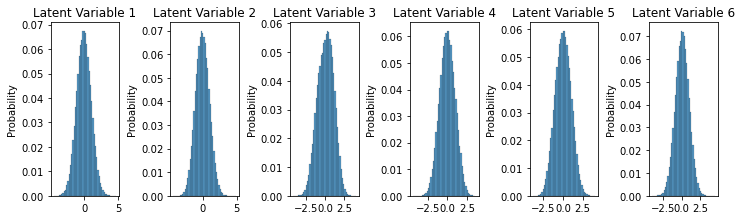

In [12]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1}")

In [13]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 15.190338134765625


In [14]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

In [15]:
# # Show distributions of the resulting variables
# fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
# fig.tight_layout(h_pad=20)

# for i, col in enumerate(VAR_NAMES):
#     sns.histplot(test_results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
#     axes[i,0].set_title(col)
#     axes[i,0].set_xlabel(None)
#     sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
#     axes[i,1].set_title(col)
#     axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [16]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# How many variables represent each household
HH_DIM = 5

In [17]:
# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

# How many synthetic households to fill
POP_SIZE = len(synth_hh_ohe_df)
print(POP_SIZE)

231781


In [18]:
# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Load the most recently trained model
# vae = keras.models.load_model('person_synthesizer')

start_time = time.time()

# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])

print(f"--- {time.time() - start_time} seconds ---")

del epsilon

# Convert the test results from logits to values
synth_p_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
synth_p_df.columns = VAR_NAMES

# Assign the control variables from the synthetic households to individuals (replace what came from the model)
for var in HH_VAR_NAMES[1:]:
    synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

# Save the synthesized persons
synth_p_df.to_csv('data/synthetic_populations/wa_persons.csv', index=False)

--- 7.371381044387817 seconds ---


<ipython-input-19-370640e01e01>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=40)


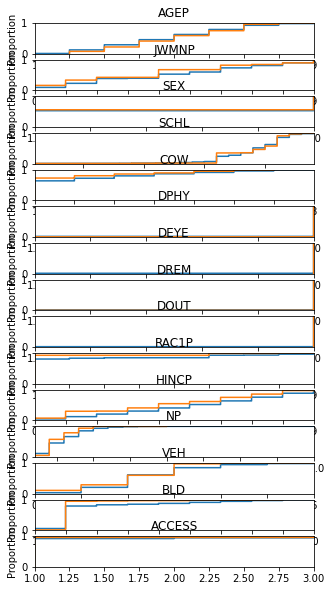

In [19]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=40)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_p_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)

In [20]:
# # Show distributions of the resulting variables
# fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,20))
# fig.tight_layout(h_pad=4)

# for i, col in enumerate(VAR_NAMES):
#     sns.histplot(synth_p_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
#     axes[i,0].set_title(col)
#     axes[i,0].set_xlabel(None)
#     sns.histplot(pums_data[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
#     axes[i,1].set_title(col)
#     axes[i,1].set_xlabel(None)

In [21]:
testModel(test_vae=vae, latent_dim=LATENT_DIM)
# gen_time, srmse_uni, srmse_bi

Univariate (marginal) SRMSE: 0.045846595137208256
Bivariate (joint) SRMSE: 0.01220685639052894


(7.756338357925415, 0.045846595137208256, 0.01220685639052894)